TEMAT PROJEKTU:

Analiza danych dotyczących wypadków samochodowych w NY


ZAŁOŻENIA:

Zgodnie z otrzymanymi danymi zadaniem analizy ma być: 

1. Określenie najniebezpieczniejszych czynników wypadków w każdej z dzielnic NY.
2. Zaprezentowanie, ile zgonów oraz obrażeń zostało spowodowanych przez szybką jazdę w danej dzielnicy.
3. Określenie 3 najczęstszych czynników wypadków z podziałem na dzielnice oraz ogółem dla całego miasta.
4. Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach.
5. Statystykę ilości wypadków dla każdej z dzielnic.
6. Najczęstsze miejsca wystąpienia wypadków.

Dla celów projektowych stworzono następujące założenia:
1. Do określenia najniebezpieczniejszych czynników wypadków w każdej dzielnicy Nowego Jorku zostało przyjęte założenie, że miarą najniebezpieczniejszych czynników wypadków jest liczba ofiar śmiertelnych. 
2. Przed wykonaniem selekcji 3 najczęstszych czynników wypadków z podziałem na dzielnice oraz ogółem dla całego miasta została wyłączona kategoria ‘Unknown’.
3. W celu określenia jakie typy pojazdów uczestniczyły w wypadkach, zostały zliczone wystąpienia VEHICLE TYPE CODE 1 oraz VEHICLE TYPE CODE 2. Do wykonania zliczenia konieczne było ujednolicenie kategorii: 'STATION WAGON/SPORT UTILITY VEHICLE','AMBULANCE' i 'BIBYCLE' które zostało zrealizowane na etapie przygotowania zbioru do analizy.
4. Baza danych prezentowana na mapie została zawężona do wypadków śmiertelnych, które miały miejsce w 2018 roku. 

In [236]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

In [237]:
print("Current working directory: {0}".format(os.getcwd()))
os.chdir('C:/Users/micha/Jupyter projekty') #ustawienie folderu

Current working directory: C:\Users\micha\Jupyter projekty


Zaczytanie danych

In [238]:
#tab = pd.read_csv('nypd-motor-vehicle-collisions.csv', sep=',', low_memory=False, encoding="utf-8-sig")
tab = pd.read_csv('nypd-motor-vehicle-collisions.csv', 
	usecols = ["ACCIDENT DATE", "BOROUGH", "LATITUDE", "LONGITUDE", "LOCATION", "NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED", "CONTRIBUTING FACTOR VEHICLE 1", "CONTRIBUTING FACTOR VEHICLE 2", "CONTRIBUTING FACTOR VEHICLE 3", "CONTRIBUTING FACTOR VEHICLE 4", "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID", "VEHICLE TYPE CODE 1", "VEHICLE TYPE CODE 2", "VEHICLE TYPE CODE 3", "VEHICLE TYPE CODE 4", "VEHICLE TYPE CODE 5" ],
sep=',', low_memory=False, encoding="utf-8-sig")



sprawdzenie datatype

In [239]:
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612178 entries, 0 to 1612177
Data columns (total 18 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   ACCIDENT DATE                  1612178 non-null  object 
 1   BOROUGH                        1127553 non-null  object 
 2   LATITUDE                       1415893 non-null  float64
 3   LONGITUDE                      1415893 non-null  float64
 4   LOCATION                       1415893 non-null  object 
 5   NUMBER OF PERSONS INJURED      1612161 non-null  float64
 6   NUMBER OF PERSONS KILLED       1612145 non-null  float64
 7   CONTRIBUTING FACTOR VEHICLE 1  1607854 non-null  object 
 8   CONTRIBUTING FACTOR VEHICLE 2  1396127 non-null  object 
 9   CONTRIBUTING FACTOR VEHICLE 3  104254 non-null   object 
 10  CONTRIBUTING FACTOR VEHICLE 4  21789 non-null    object 
 11  CONTRIBUTING FACTOR VEHICLE 5  5622 non-null     object 
 12  COLLISION_ID  

Czyszczenie danych

Usinięcie duplikatow

In [240]:
tab = tab.drop_duplicates(subset="COLLISION_ID")

Zmiana datatype

In [241]:
tab['ACCIDENT DATE'] = pd.to_datetime(tab['ACCIDENT DATE'])

Poprawienie literowek

In [242]:
tab['CONTRIBUTING FACTOR VEHICLE 1'] = tab['CONTRIBUTING FACTOR VEHICLE 1'].str.replace('Cell Phone (hand-Held)','Cell Phone (hand-held)').astype(str)
tab['CONTRIBUTING FACTOR VEHICLE 1'] = tab['CONTRIBUTING FACTOR VEHICLE 1'].str.replace('Illness', 'Illnes').astype(str)
tab['CONTRIBUTING FACTOR VEHICLE 1'] = tab['CONTRIBUTING FACTOR VEHICLE 1'].str.replace('Illegal', 'illegal').astype(str)

tab['CONTRIBUTING FACTOR VEHICLE 1'] = tab['CONTRIBUTING FACTOR VEHICLE 1'].str.replace('UNKNOWN','Unknown').astype(str)
tab['CONTRIBUTING FACTOR VEHICLE 1'] = tab['CONTRIBUTING FACTOR VEHICLE 1'].str.replace('Unspecified','Unknown').astype(str)

tab['VEHICLE TYPE CODE 1'] = tab['VEHICLE TYPE CODE 1'].str.upper()
tab['VEHICLE TYPE CODE 2'] = tab['VEHICLE TYPE CODE 2'].str.upper()

Ujednolicenie kategorii pojazdow

In [243]:
tab.loc[tab['VEHICLE TYPE CODE 1'] == 'AMB', 'VEHICLE TYPE CODE 1'] = 'AMBULANCE'
tab.loc[tab['VEHICLE TYPE CODE 1'] == 'AMBU', 'VEHICLE TYPE CODE 1'] = 'AMBULANCE'
tab.loc[tab['VEHICLE TYPE CODE 1'] == 'AMBUL', 'VEHICLE TYPE CODE 1'] = 'AMBULANCE'

tab.loc[tab['VEHICLE TYPE CODE 1'] == 'BICYC', 'VEHICLE TYPE CODE 1'] = 'BICYCLE'
tab.loc[tab['VEHICLE TYPE CODE 1'] == 'BIKE', 'VEHICLE TYPE CODE 1'] = 'BICYCLE'

tab.loc[tab['VEHICLE TYPE CODE 1']  == 'STATION WAGON/SPORT UTILITY VEHICLE', 'VEHICLE TYPE CODE 1'] = 'SPORT UTILITY / STATION WAGON'
tab.loc[tab['VEHICLE TYPE CODE 2']  == 'STATION WAGON/SPORT UTILITY VEHICLE', 'VEHICLE TYPE CODE 2'] = 'SPORT UTILITY / STATION WAGON'



Określenie najniebezpieczniejszych czynników wypadków w każdej dzielnicy NY

In [244]:
zad1 = tab.groupby(['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1']).agg(number_of_accidents=('BOROUGH', 'count'),
                                                                     PERSONS_INJURED=(
                                                                     'NUMBER OF PERSONS INJURED', 'sum'),
                                                                     PERSONS_KILLED=('NUMBER OF PERSONS KILLED', 'sum'))

Wybór pięciu najniebezpieczniejszych czynników wypadków w każdej dzielnicy NY okreslonej na podstawie liczby ofiar smiertelnych

          BOROUGH                      CONTRIBUTING FACTOR VEHICLE 1  \
0           BRONX                                            Unknown   
1           BRONX                      Failure to Yield Right-of-Way   
2           BRONX                        Traffic Control Disregarded   
3           BRONX                     Driver Inattention/Distraction   
4           BRONX                              Passenger Distraction   
5        BROOKLYN                                            Unknown   
6        BROOKLYN                     Driver Inattention/Distraction   
7        BROOKLYN                      Failure to Yield Right-of-Way   
8        BROOKLYN                        Traffic Control Disregarded   
9        BROOKLYN                                       Unsafe Speed   
10      MANHATTAN                                            Unknown   
11      MANHATTAN                      Failure to Yield Right-of-Way   
12      MANHATTAN                     Driver Inattention/Distrac

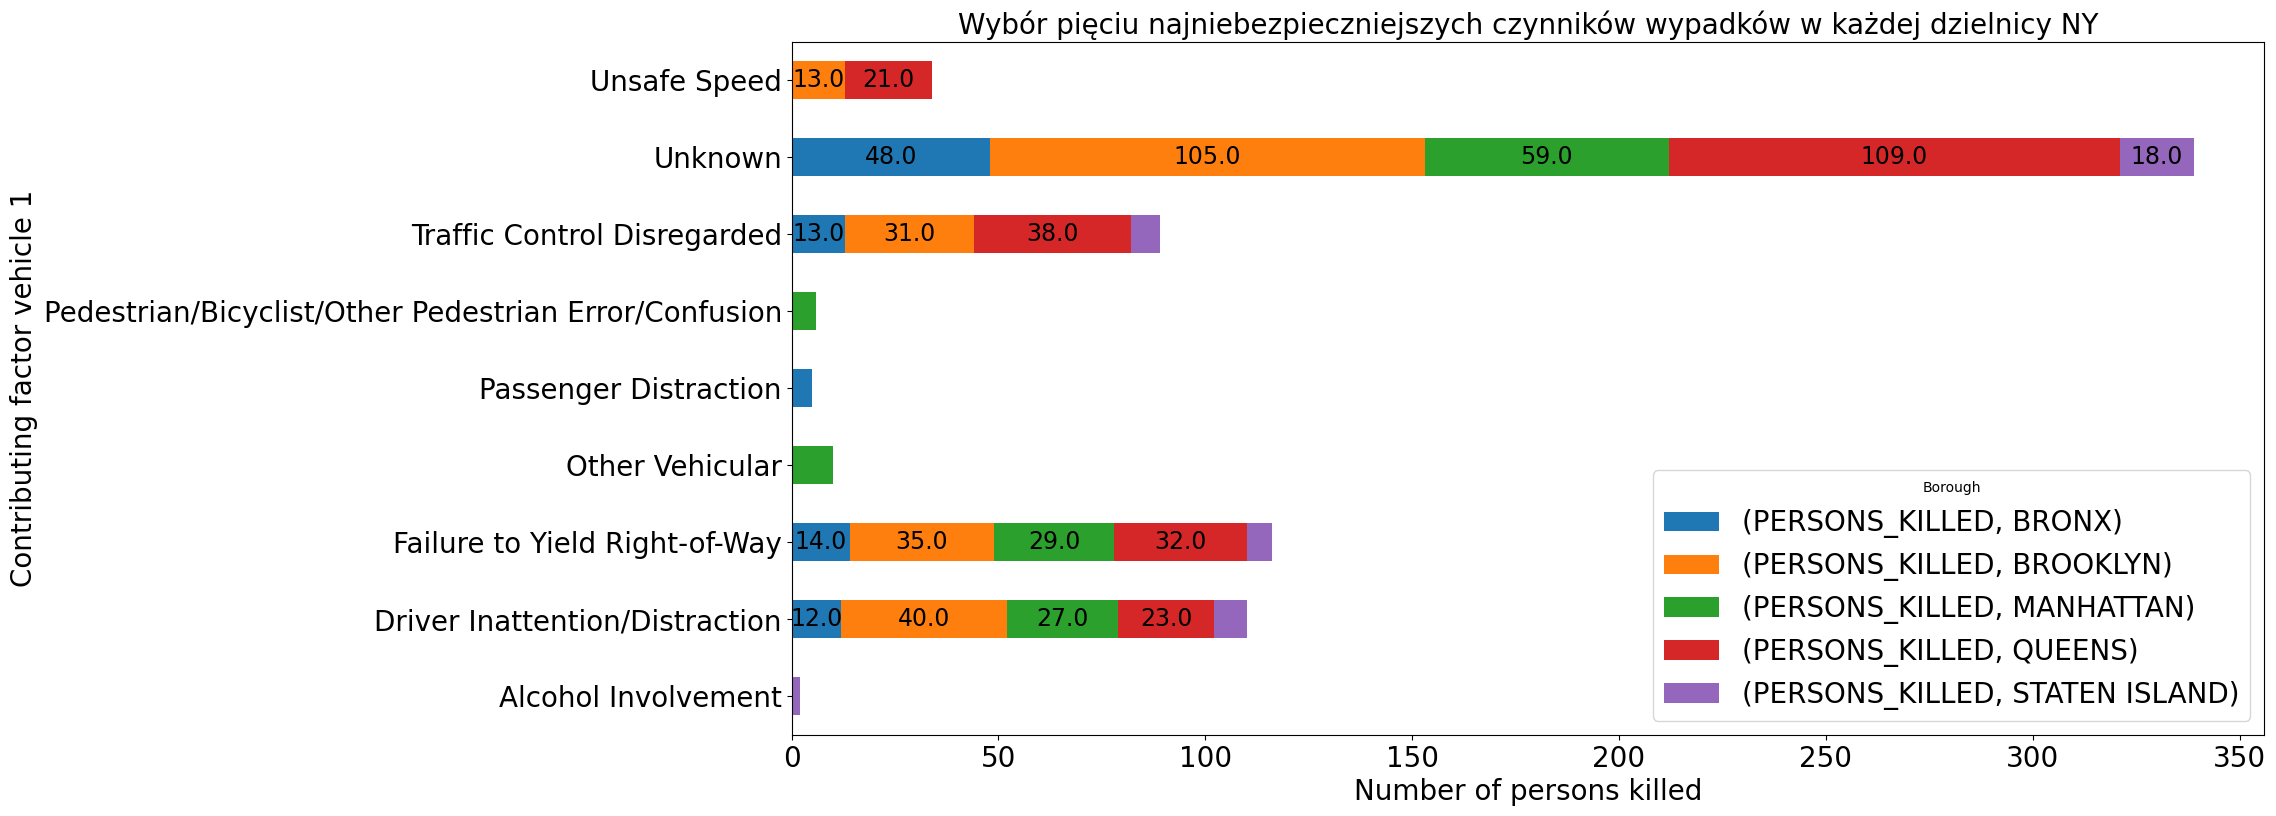

In [245]:
tab1 = zad1.groupby('BOROUGH')['PERSONS_KILLED'].nlargest(5).to_frame()
tab1 = tab1.reset_index(level=0, drop=True).reset_index()

print(tab1)

pivot = tab1.pivot_table(index=['CONTRIBUTING FACTOR VEHICLE 1', 'BOROUGH'],
                         values=['PERSONS_KILLED'], aggfunc='sum').unstack()
pivot = pivot.replace(to_replace=np.nan, value=0)

ax = pivot.plot(kind='barh', stacked=True, figsize=(19, 9),
                title='Wybór pięciu najniebezpieczniejszych czynników wypadków w każdej dzielnicy NY', fontsize=20)

for c in ax.containers:
    # etykiety
    labels = [f'{w}' if ((w := v.get_width()) > 0 and w > 10) else '' for v in c]

    ax.bar_label(c, labels=labels, label_type='center', fontsize=17)

ax.set_title('Wybór pięciu najniebezpieczniejszych czynników wypadków w każdej dzielnicy NY', fontsize=20)
ax.set_xlabel('Number of persons killed', fontsize=20)
ax.set_ylabel('Contributing factor vehicle 1', fontsize=20)
ax.legend(title='Borough', fontsize=20)

plt.show()


Zaprezentowanie, ile zgonów oraz obrażeń zostało spowodowanych przez szybką jazdę w danej dzielnicy

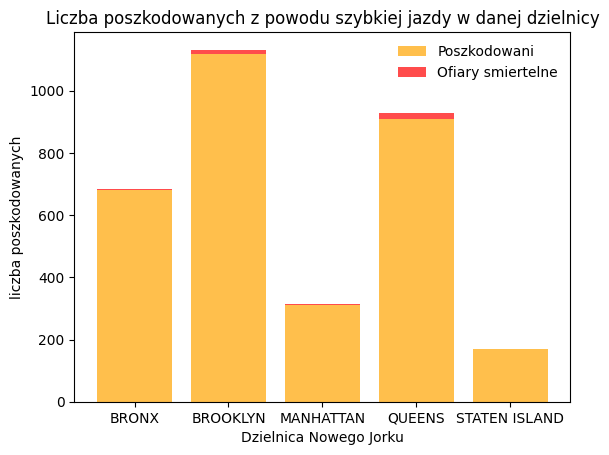

In [246]:
zad2 = zad1.reset_index()
zad2 = zad2[(zad2['CONTRIBUTING FACTOR VEHICLE 1'] == "Unsafe Speed")]

plt.bar(zad2['BOROUGH'], zad2["PERSONS_INJURED"], color='orange', alpha=0.7, label='Poszkodowani')
plt.bar(zad2['BOROUGH'], zad2["PERSONS_KILLED"], color='red', alpha=0.7, label='Ofiary smiertelne',
        bottom=zad2["PERSONS_INJURED"])

plt.legend(frameon=False)
plt.xlabel('Dzielnica Nowego Jorku')
plt.ylabel('liczba poszkodowanych')
plt.title('Liczba poszkodowanych z powodu szybkiej jazdy w danej dzielnicy');

plt.show()

Określenie 3 najczęstszych czynników wypadków z podziałem na dzielnice oraz ogółem dla całego miasta (na podstawie liczby wszystkich zarejestrowanych wypadków)

In [247]:
zad3 = tab[(tab['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unknown')]  # wyłączenie 'CONTRIBUTING FACTOR VEHICLE 1' == 'Unknown'
zad3 = zad3.groupby(['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1']).agg(number_of_accidents=('BOROUGH', 'count'))
tab3a = zad3.groupby('BOROUGH')['number_of_accidents'].nlargest(3).to_frame()  # z podziałem na dzielnice
tab3a = tab3a.reset_index(level=0, drop=True).reset_index()

print('Określenie 3 najczęstszych czynników wypadków z podziałem na dzielnice')
print(tab3a)

# ogółem dla calego miasta
zad3 = zad3.reset_index()
tab3b = zad3.groupby(['CONTRIBUTING FACTOR VEHICLE 1']).agg(number_of_accidents=('number_of_accidents', 'sum'))
tab3b = tab3b.sort_values("number_of_accidents", ascending=False).iloc[:3]

print("")
print('Określenie 3 najczęstszych czynników wypadków dla całego miasta')
print(tab3b)

Określenie 3 najczęstszych czynników wypadków z podziałem na dzielnice
          BOROUGH   CONTRIBUTING FACTOR VEHICLE 1  number_of_accidents
0           BRONX  Driver Inattention/Distraction                17773
1           BRONX                 Other Vehicular                 5447
2           BRONX                Backing Unsafely                 5278
3        BROOKLYN  Driver Inattention/Distraction                40747
4        BROOKLYN   Failure to Yield Right-of-Way                16913
5        BROOKLYN                Backing Unsafely                10922
6       MANHATTAN  Driver Inattention/Distraction                40646
7       MANHATTAN                 Other Vehicular                12537
8       MANHATTAN   Failure to Yield Right-of-Way                 9236
9          QUEENS  Driver Inattention/Distraction                46255
10         QUEENS   Failure to Yield Right-of-Way                18654
11         QUEENS                Backing Unsafely                11623
12  ST

Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach

In [248]:
zad4a = tab.groupby('VEHICLE TYPE CODE 1').agg(number_of_accidents=('BOROUGH', 'count')).reset_index()
zad4a = zad4a.rename(columns={"VEHICLE TYPE CODE 1": "VEHICLE TYPE CODE"})

zad4b = tab.groupby('VEHICLE TYPE CODE 2').agg(number_of_accidents=('BOROUGH', 'count')).reset_index()
zad4b = zad4b.rename(columns={"VEHICLE TYPE CODE 2": "VEHICLE TYPE CODE"})

zad4c = pd.concat([zad4a, zad4b])

zad4c = zad4c.groupby('VEHICLE TYPE CODE').agg(number_of_accidents=('number_of_accidents', 'sum'))
zad4c = zad4c.sort_values("number_of_accidents", ascending=False).iloc[:10]

print("")
print('Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach - pojazd pierwszy i drugi sumarycznie')
print(zad4c)

zad4a = zad4a.sort_values("number_of_accidents", ascending=False).iloc[:10]
print("")
print('Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach - pojazd pierwszy')
print(zad4a)

zad4b = zad4b.sort_values("number_of_accidents", ascending=False).iloc[:10]
print("")
print('Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach - pojazd drugi')
print(zad4b)


Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach - pojazd pierwszy i drugi sumarycznie
                               number_of_accidents
VEHICLE TYPE CODE                                 
PASSENGER VEHICLE                           639143
SPORT UTILITY / STATION WAGON               400334
SEDAN                                       141045
TAXI                                         71395
UNKNOWN                                      60879
PICK-UP TRUCK                                33546
VAN                                          32899
OTHER                                        28134
BUS                                          22743
BICYCLE                                      22257

Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach - pojazd pierwszy
                 VEHICLE TYPE CODE  number_of_accidents
280              PASSENGER VEHICLE               368324
348  SPORT UTILITY / STATION WAGON               229554
333                          SEDAN  

Statystyka ilości wypadków dla każdej z dzielnic

Statystyka liczby wypadków dla każdej z dzielnic
         BOROUGH  number_of_accidents
0          BRONX               118701
1       BROOKLYN               263285
2      MANHATTAN               203102
3         QUEENS               225555
4  STATEN ISLAND                36743


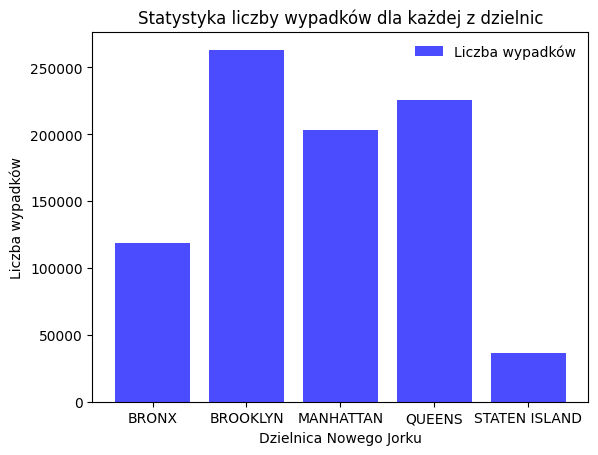

In [249]:
zad5 = tab.groupby(['BOROUGH']).agg(number_of_accidents=('BOROUGH', 'count'))
zad5 = zad5.reset_index()

print('Statystyka liczby wypadków dla każdej z dzielnic')
print(zad5)

plt.bar(zad5['BOROUGH'], zad5["number_of_accidents"], color='blue', alpha=0.7, label='Liczba wypadków')

plt.legend(frameon=False)
plt.xlabel('Dzielnica Nowego Jorku')
plt.ylabel('Liczba wypadków')
plt.title('Statystyka liczby wypadków dla każdej z dzielnic')

plt.show()

Najczęstsze miejsca wystąpienia wypadków

In [250]:
tab6 = tab.dropna(subset=["LOCATION"])
tab6 = tab6.copy()

#tab6['year'] = tab6['ACCIDENT DATE'].dt.year
tab6.loc[:, 'year'] = tab6['ACCIDENT DATE'].dt.year

# wybór lokalizacji wypadków smiertelnych mających miejsce w 2018 roku
# w związku z tym, że baza danych jest ogromna zawężyłem bazę danych do wybranego roku i wypadków smiertelnych
# bez filtrowania mapa nie była wyswietlana (a nawet jesli by się udało to byłaby kompletnie nieczytelna)


tab6 = tab6[(tab6['year']==2018)]
tab6 = tab6.dropna(subset=["NUMBER OF PERSONS KILLED"])
tab6 = tab6[(tab6['NUMBER OF PERSONS KILLED']!=0)]

# Create a map centered at the average coordinates
average_lat = tab6['LATITUDE'].mean()
average_lon = tab6['LONGITUDE'].mean()
my_map = folium.Map(location=[average_lat, average_lon], zoom_start=10)

# Add markers to the map
for index, row in tab6.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']]#,
       # popup=row['name']
    ).add_to(my_map)
    
#my_map.save("mymap.html")
my_map

Wnioski:

Otrzymane dane wymagały wstępnej ekpoloracji w celu przygotowania zbioru do analizy. Analiza została przeprowadzona po usunięciu duplikatów, ujednoliceniu typu pojazdów i kategorii czynników wyadków.

Przed opisem wykonanej analizy koniecznym jest podkreślenie, że wyniki oraz wnioski są zależne od przyjętych założeń.
Do określenia najniebezpieczniejszych czynników wypadków w każdej dzielnicy Nowego Jorku zostało przyjęte założenie, że miarą najniebezpieczniejszych czynników wypadków jest liczba ofiar śmiertelnych. Do prezentacji opisanej statystyki został wykorzystany wykres kolumnowy skumulowany, dzięki któremu istnieje możliwość porównania na jednej grafice czynników mających wpływ na wystąpienie wypadków ze skutkiem śmiertelnym dla wszystkich dzielnic. Wartym rozważenia w dalszej eksploracji byłoby wyłączenie kategorii ‘Unspecified’ spośród czynników wypadków.

Liczba ofiar śmiertelnych i poszkodowanych z powodu szybkiej jazdy również została zaprezentowana na wykresie kolumnowym skumulowanym. W Brooklynie odnotowano najwyższą spośród wszystkich dzielnic liczbę poszkodowanych przekraczającą 1000 osób. Interesującym krokiem byłoby przedstawienie opisanej analizy z podziałem na lata, w których miało miejsce zdarzenie.

Przed wykonaniem selekcji 3 najczęstszych czynników wypadków z podziałem na dzielnice oraz ogółem dla całego miasta została wyłączona wspomniana wcześniej kategoria ‘Unspecified’. Najczęstszą przyczyną wypadków w każdej z dzielnic okazała się nieuwaga kierowcy.

W celu określenia jakie typy pojazdów uczestniczyły w wypadkach, zostały zliczone wystąpienia VEHICLE TYPE CODE 1 oraz VEHICLE TYPE CODE 2. Do wykonania zliczenia konieczne było ujednolicenie kategorii: ‘STATION WAGON/SPORT UTILITY VEHICLE’, które zostało zrealizowane na etapie przygotowania zbioru do analizy.

Najczęstsze miejsca wystąpienia wypadków zostały przedstawione z wykorzystaniem biblioteki folium. Baza danych prezentowana na mapie została zawężona do wypadków śmiertelnych, które miały miejsce w 2018 roku.

Analizowany zbiór danych umożliwia przeprowadzenie kolejnych analiz, np.:
-	statystyka dotycząca godziny zdarzenia – w jakich godzinach wypadki statystycznie zdarzają się najczęściej;
-	statystyki dotyczące udziału pieszych i rowerzystów w wypadkach;
-	przedstawienie zdarzeń w ujęciu rocznym w podziale na poszczególne dzielnice i całe miasto.